<a href="https://colab.research.google.com/github/matheusfigueiredoo/detection-of-cyber-attacks/blob/main/%5B1%5D_bin_mqttset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

Mounted at /content/drive


# Pre processing data

In [2]:
train = pd.read_csv("drive/MyDrive/MQTTset/train70_augmented.csv")
test = pd.read_csv("drive/MyDrive/MQTTset/test30_augmented.csv")
train = pd.DataFrame(train)
test = pd.DataFrame(test)

# data shape
print("Train shape: ", train.shape)
print("Test shape: ", test.shape, "\n")

print("Train target:\n", train['target'].value_counts())
print("Test target:\n",test['target'].value_counts())

Train shape:  (14000000, 34)
Test shape:  (6000000, 34) 

Train target:
 target
legitimate    7000000
bruteforce    1400000
flood         1400000
slowite       1400000
dos           1400000
malformed     1400000
Name: count, dtype: int64
Test target:
 target
legitimate    3000000
dos            600000
slowite        600000
flood          600000
bruteforce     600000
malformed      600000
Name: count, dtype: int64


In [3]:
# features countais only values equal to 0
print(train['mqtt.conack.flags.reserved'].unique())
print(train['mqtt.conack.flags.sp'].unique())
print(train['mqtt.conflag.qos'].unique())
print(train['mqtt.conflag.reserved'].unique())
print(train['mqtt.conflag.retain'].unique())
print(train['mqtt.conflag.willflag'].unique())
print(train['mqtt.sub.qos'].unique())
print(train['mqtt.suback.qos'].unique())
print(train['mqtt.willmsg'].unique())
print(train['mqtt.willmsg_len'].unique())
print(train['mqtt.willtopic'].unique())
print(train['mqtt.willtopic_len'].unique())

[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]


In [ ]:
# columns_0 are columns with values equal to 0
columns_0 = ['mqtt.conack.flags.reserved', 'mqtt.conack.flags.sp', 'mqtt.conflag.qos',
           'mqtt.conflag.reserved', 'mqtt.conflag.retain', 'mqtt.conflag.willflag',
           'mqtt.sub.qos', 'mqtt.suback.qos', 'mqtt.willmsg', 'mqtt.willmsg_len',
           'mqtt.willtopic', 'mqtt.willtopic_len']

train = train.drop(columns_0, axis=1)
test = test.drop(columns_0, axis=1)

# new data shape
print(train.shape)
print(test.shape)

(14000000, 22)
(6000000, 22)


In [ ]:
# data balancing

# train
for i in train.index:
    if train['target'][i] != 'legitimate':
        train.at[i, 'target'] = 'malicious'

# test
for i in test.index:
    if test['target'][i] != 'legitimate':
        test.at[i, 'target'] = 'malicious'

# new data shape
print(train['target'].value_counts())
print(test['target'].value_counts())

target
legitimate    7000000
malicious     7000000
Name: count, dtype: int64
target
malicious     3000000
legitimate    3000000
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()

# features and target
train['tcp.flags'] = label.fit_transform(train['tcp.flags'])
train['mqtt.conack.flags'] = label.fit_transform(train['mqtt.conack.flags'])
train['mqtt.hdrflags'] = label.fit_transform(train['mqtt.hdrflags'])
train['mqtt.protoname'] = label.fit_transform(train['mqtt.protoname'])
train['mqtt.msg'] = label.fit_transform(train['mqtt.msg'])
train['mqtt.conflags'] = label.fit_transform(train['mqtt.conflags'])
train['target'] = label.fit_transform(train['target'])

test['tcp.flags'] = label.fit_transform(test['tcp.flags'])
test['mqtt.conack.flags'] = label.fit_transform(test['mqtt.conack.flags'])
test['mqtt.hdrflags'] = label.fit_transform(test['mqtt.hdrflags'])
test['mqtt.protoname'] = label.fit_transform(test['mqtt.protoname'])
test['mqtt.msg'] = label.fit_transform(test['mqtt.msg'])
test['mqtt.conflags'] = label.fit_transform(test['mqtt.conflags'])
test['target'] = label.fit_transform(test['target'])

In [ ]:
X_train = train.iloc[:,:-1]
y_train = train['target']
X_test = test.iloc[:,:-1]
y_test = test['target']

print(type(X_train))
print(type(X_test))
print(type(y_train))
print(type(y_test))

# convert to numpy
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

print(type(X_train))
print(type(X_test))
print(type(y_train))
print(type(y_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# Decision Tree

Accuracy train:  0.9603655714285714
Cross-validation scores: [0.96035714 0.9605125  0.960285   0.96031214 0.96035536]
Average cross-validation score: 0.96 

Accuracy test:  0.9606431666666667 

Classification report: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96   3000000
           1       0.98      0.94      0.96   3000000

    accuracy                           0.96   6000000
   macro avg       0.96      0.96      0.96   6000000
weighted avg       0.96      0.96      0.96   6000000
 

Confusion matrix: 
 [[2954845   45155]
 [ 190986 2809014]] 



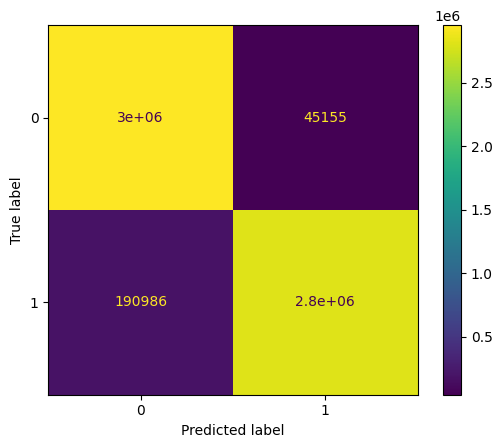

In [ ]:
tree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, random_state=42)
tree.fit(X_train, y_train)

print("Accuracy train: ", tree.score(X_train, y_train))

# cross validation
scores = cross_val_score(tree, X_train, y_train, cv=5)
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()),"\n")
print("Accuracy test: ", tree.score(X_test, y_test), "\n")

# classification report
predict_tree = tree.predict(X_test)
print("Classification report: ")
print(classification_report(y_test, predict_tree), "\n")

# confusion matrix
matrix_tree = confusion_matrix(y_test, predict_tree)
print("Confusion matrix: \n",matrix_tree, "\n")
cm_tree = confusion_matrix(y_test, predict_tree, labels=tree.classes_)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=tree.classes_)
disp_tree.plot()
plt.show()

# Random Forest

Accuracy train:  0.9603655714285714
Cross-validation scores: [0.96035964 0.9605125  0.96028536 0.96031214 0.96035571]
Average cross-validation score: 0.96 

Accuracy test:  0.9606433333333333 

Classification report: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96   3000000
           1       0.98      0.94      0.96   3000000

    accuracy                           0.96   6000000
   macro avg       0.96      0.96      0.96   6000000
weighted avg       0.96      0.96      0.96   6000000
 

Confusion matrix:
 [[2954846   45154]
 [ 190986 2809014]] 



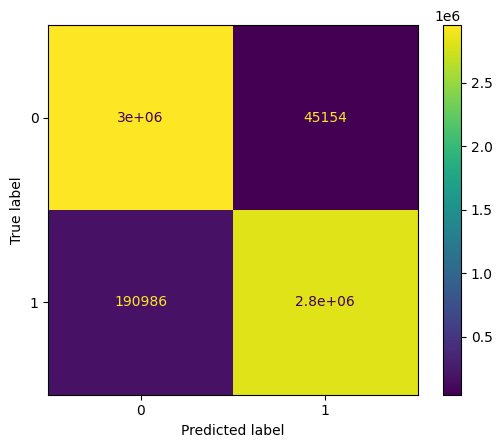

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print("Accuracy train: ", rf.score(X_train, y_train))

# cross validation
scores_rf = cross_val_score(rf, X_train, y_train, cv=5)
print("Cross-validation scores: {}".format(scores_rf))
print("Average cross-validation score: {:.2f}".format(scores_rf.mean()),"\n")

print("Accuracy test: ", rf.score(X_test, y_test), "\n")


# classification report
predict_rf = rf.predict(X_test)
print("Classification report: ")
print(classification_report(y_test, predict_rf), "\n")

# confusion matrix
matrix_rf = confusion_matrix(y_test, predict_rf)
print("Confusion matrix:\n", matrix_rf, "\n")
cm_rf = confusion_matrix(y_test, predict_rf, labels=rf.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf.classes_)
disp_rf.plot()
plt.show()

# Multi-layer perceptron

Accuracy train:  0.9217502142857142
Cross-validation scores: [0.92178071 0.92465286 0.92444571 0.92381429 0.92167643]
Average cross-validation score: 0.92 

Accuracy test:  0.9219808333333334 

Classification report: 
              precision    recall  f1-score   support

           0       0.87      0.99      0.93   3000000
           1       0.98      0.86      0.92   3000000

    accuracy                           0.92   6000000
   macro avg       0.93      0.92      0.92   6000000
weighted avg       0.93      0.92      0.92   6000000
 

Confusion matrix:
 [[2955046   44954]
 [ 423161 2576839]] 



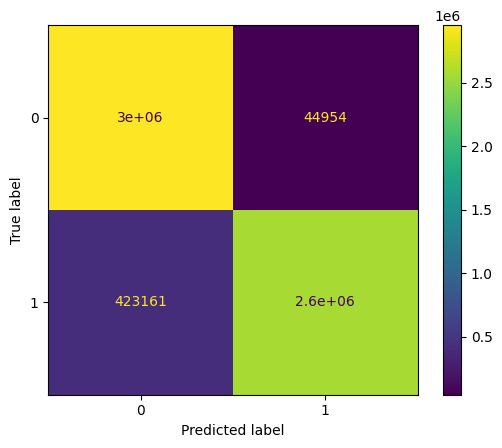

In [ ]:
mlp = MLPClassifier(solver='adam', shuffle=True, random_state=0, alpha=0.0000001)
mlp.fit(X_train, y_train)
print("Accuracy train: ", mlp.score(X_train, y_train))

# cross validation
scores_mlp = cross_val_score(mlp, X_train, y_train, cv=5)
print("Cross-validation scores: {}".format(scores_mlp))
print("Average cross-validation score: {:.2f}".format(scores_mlp.mean()),"\n")

print("Accuracy test: ", mlp.score(X_test, y_test), "\n")

# classification report
predict_mlp = mlp.predict(X_test)
print("Classification report: ")
print(classification_report(y_test, predict_mlp), "\n")

# confusion matrix
matrix_mlp = confusion_matrix(y_test, predict_mlp)
print("Confusion matrix:\n", matrix_mlp, "\n")
cm_mlp = confusion_matrix(y_test, predict_mlp, labels=mlp.classes_)
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=mlp.classes_)
disp_mlp.plot()
plt.show()